<a href="https://colab.research.google.com/github/Mahsa33/Group-Seating-Arrangement/blob/main/Group_SeatingArrangment_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [2]:
first_names = [
    "آرمان",
    "نیلوفر",
    "سامان",
    "آتنا",
    "آریا",
    "آیدین",
    "شایان",
    "رویا",
    "شهرزاد",
    "پارسا",
    "روزبه",
    "زهرا",
    "مهران",
    "مریم",
    "کیان",
    "شبنم",
    "سینا",
    "نازنین",
    "میترا",
    "کامران"
]

last_names = [
    "خرم‌آبادی",
    "میرزایی",
    "احمدی",
    "رضایی",
    "قاسمی",
    "کریمی",
    "نجفی",
    "محمدی",
    "صادقی",
    "علیزاده",
    "رحمانی",
    "اسماعیلی",
    "کاظمی",
    "رستمی",
    "بهرامی",
    "حسینی",
    "موسوی",
    "زارع",
    "جعفری",
    "حیدری"
]
names = [f"{first_name} {last_name}" for first_name in first_names for last_name in last_names]

print(len(names))
print(names)

400
['آرمان خرم\u200cآبادی', 'آرمان میرزایی', 'آرمان احمدی', 'آرمان رضایی', 'آرمان قاسمی', 'آرمان کریمی', 'آرمان نجفی', 'آرمان محمدی', 'آرمان صادقی', 'آرمان علیزاده', 'آرمان رحمانی', 'آرمان اسماعیلی', 'آرمان کاظمی', 'آرمان رستمی', 'آرمان بهرامی', 'آرمان حسینی', 'آرمان موسوی', 'آرمان زارع', 'آرمان جعفری', 'آرمان حیدری', 'نیلوفر خرم\u200cآبادی', 'نیلوفر میرزایی', 'نیلوفر احمدی', 'نیلوفر رضایی', 'نیلوفر قاسمی', 'نیلوفر کریمی', 'نیلوفر نجفی', 'نیلوفر محمدی', 'نیلوفر صادقی', 'نیلوفر علیزاده', 'نیلوفر رحمانی', 'نیلوفر اسماعیلی', 'نیلوفر کاظمی', 'نیلوفر رستمی', 'نیلوفر بهرامی', 'نیلوفر حسینی', 'نیلوفر موسوی', 'نیلوفر زارع', 'نیلوفر جعفری', 'نیلوفر حیدری', 'سامان خرم\u200cآبادی', 'سامان میرزایی', 'سامان احمدی', 'سامان رضایی', 'سامان قاسمی', 'سامان کریمی', 'سامان نجفی', 'سامان محمدی', 'سامان صادقی', 'سامان علیزاده', 'سامان رحمانی', 'سامان اسماعیلی', 'سامان کاظمی', 'سامان رستمی', 'سامان بهرامی', 'سامان حسینی', 'سامان موسوی', 'سامان زارع', 'سامان جعفری', 'سامان حیدری', 'آتنا خرم\u200cآبادی', 'آتن

In [6]:
import random
import torch
import matplotlib.pyplot as plt

class SeatingArrangement:
    def __init__(self, num_people, rows, cols):
        self.num_people = num_people
        self.rows = rows
        self.cols = cols
        self.seating_order = self.generate_seating_order()
        self.groups = self.create_groups()
        #self.group_matrix = self.shuffle_groups_and_create_matrix()
        self.conflict_matrix_person = None
        self.conflict_matrix_group_ref = None

    def generate_seating_order(self):
        person_ids = [i for i in range(self.num_people)]
        random.shuffle(person_ids)

        seating_order = torch.zeros(self.rows, self.cols)
        k = 0
        for i in range(self.rows):
            for j in range(self.cols):
                seating_order[i, j] = person_ids[k]
                k += 1

        return seating_order.float()

    def create_groups(self):
        groups_lst = [self.seating_order[i][j:j+5]  for i in range(self.seating_order.shape[0]) for j in range(0, self.seating_order.shape[1], 5)]
        groups = {i: groups_lst[i].tolist() for i in range(len(groups_lst))}

        print('Number of groups:', len(groups))
        print('********************************')
        return groups


    def find_group(self, num):
        for i, group in self.groups.items():
            if num in group:
                return i
        return -1

    def create_conflict_matrix_person(self):
        conflict_matrix = torch.zeros(self.num_people, self.num_people)
        count_one = 0
        incompatible_pairs = []

        while count_one < 600:
            i = random.randint(0, self.num_people-1)
            j = random.randint(0, self.num_people-1)
            i_group = self.find_group(i)
            j_group = self.find_group(j)

            if i_group != j_group and conflict_matrix[i][j] == 0:
                conflict_matrix[i][j] = 1
                count_one += 1
                incompatible_pairs.append((i, j))

        self.conflict_matrix_person = conflict_matrix.float()
        return incompatible_pairs

    def create_conflict_matrix_group(self):
        conflict_matrix = torch.zeros(len(self.groups), len(self.groups))

        for i, group_i in self.groups.items():
            for j, group_j in self.groups.items():
                if i != j:
                    conflict = sum(self.conflict_matrix_person[int(person_i), int(person_j)] for person_i in group_i for person_j in group_j)
                    conflict_matrix[i, j] = conflict

        self.conflict_matrix_group_ref = conflict_matrix
        return self.conflict_matrix_group_ref


    def find_number_of_compatibility(self, conflict_matrix_group_ref):
      compatiblity = 0
      compatiblity_dict = {}

      for i in range(conflict_matrix_group_ref.shape[0]):
        for j in range(conflict_matrix_group_ref.shape[1]):
          if conflict_matrix_group_ref[i][j] == 0:
            compatiblity += 1

        compatiblity_dict [i] = compatiblity
        compatiblity = 0

      return compatiblity_dict




In [7]:
rows, cols = 40 , 10
num_people = 400

seating_arrangement = SeatingArrangement(400, 40, 10)

seating_order = seating_arrangement.seating_order
print('seating_order for 400 people:', seating_order)

incompatible_persons_ref = seating_arrangement.create_conflict_matrix_person()
print('incompatible persons in 400*400 matrix:', incompatible_persons_ref)

groups = seating_arrangement.groups
print('Groups of 5 people:', groups)

incompatible_groups_ref = seating_arrangement.create_conflict_matrix_group()
print('incompatible groups in 80*80 matrix:', incompatible_groups_ref)


num_compatible_group_with_each = seating_arrangement.find_number_of_compatibility(incompatible_groups_ref)
print('this dictionary indicate compatibility of each group with other groups:', num_compatible_group_with_each)

Number of groups: 80
********************************
seating_order for 400 people: tensor([[ 56., 337., 343., 280., 366., 292., 289., 341.,  99., 179.],
        [ 17., 236., 279., 170., 211., 398.,  49., 284., 365., 152.],
        [156., 206., 376.,  26.,  62., 235., 249., 165., 316.,  84.],
        [344.,  42., 377.,  66., 131., 339., 153., 162., 238.,  98.],
        [373., 256., 395., 276., 326., 123., 190., 257.,  14., 103.],
        [248., 363.,  75., 334.,  39., 119., 128., 307.,  10.,  38.],
        [186., 171., 330., 144.,  13., 319., 291., 342.,  15., 333.],
        [231., 121.,  87.,  60.,  55., 202.,  63., 318.,  57., 260.],
        [352.,  52., 113., 160.,  51.,  20., 172.,   2., 196., 240.],
        [356.,  68.,  79., 124.,  12., 191., 252., 207., 181., 285.],
        [ 31., 301., 327., 221., 239.,  34., 151., 232., 135.,  19.],
        [120.,  33.,   9.,  41., 224.,  90.,  78., 399.,  29.,  77.],
        [253., 242., 108.,  71., 168., 397., 255.,  88., 296., 159.],
      

In [14]:
sorted_compatibility = dict(sorted(num_compatible_group_with_each.items(), key=lambda item: item[1], reverse=True))

print(sorted_compatibility)

sorted_keys_list = list(sorted_compatibility.keys())

random.shuffle(keys_list)
shuffld_keys_list = list(sorted_compatibility.keys())
print(shuffld_keys_list)

{55: 78, 9: 77, 31: 77, 57: 77, 65: 77, 70: 77, 33: 76, 43: 76, 44: 76, 8: 75, 19: 75, 21: 75, 27: 75, 41: 75, 45: 75, 48: 75, 58: 75, 79: 75, 5: 74, 7: 74, 12: 74, 16: 74, 22: 74, 23: 74, 36: 74, 39: 74, 40: 74, 47: 74, 51: 74, 66: 74, 67: 74, 71: 74, 75: 74, 76: 74, 77: 74, 3: 73, 14: 73, 24: 73, 26: 73, 29: 73, 34: 73, 38: 73, 42: 73, 53: 73, 60: 73, 78: 73, 2: 72, 4: 72, 15: 72, 20: 72, 25: 72, 30: 72, 32: 72, 49: 72, 50: 72, 52: 72, 61: 72, 64: 72, 73: 72, 10: 71, 17: 71, 18: 71, 28: 71, 35: 71, 46: 71, 54: 71, 59: 71, 62: 71, 68: 71, 74: 71, 6: 70, 11: 70, 13: 70, 63: 70, 0: 69, 1: 69, 37: 69, 72: 69, 69: 68, 56: 66}
[55, 9, 31, 57, 65, 70, 33, 43, 44, 8, 19, 21, 27, 41, 45, 48, 58, 79, 5, 7, 12, 16, 22, 23, 36, 39, 40, 47, 51, 66, 67, 71, 75, 76, 77, 3, 14, 24, 26, 29, 34, 38, 42, 53, 60, 78, 2, 4, 15, 20, 25, 30, 32, 49, 50, 52, 61, 64, 73, 10, 17, 18, 28, 35, 46, 54, 59, 62, 68, 74, 6, 11, 13, 63, 0, 1, 37, 72, 69, 56]


In [24]:
block_size = 80

def build_dataset(numbers, sorted_keys_list):
    X, Y = [], []

    for num in numbers:
        context = [0] * block_size

        if num in  sorted_keys_list:
              index_num = sorted_keys_list.index(num)

        for i in range(len(sorted_keys_list)):

          if index_num+i == len(sorted_keys_list):
            index = 0
          if index_num+i < len(sorted_keys_list):
            index = index_num+i
          if index_num+i > len(sorted_keys_list) :
            index += 1

          ix = sorted_keys_list[index]
          X.append(context)
          Y.append(ix)
          context = context[1:] + [ix]  # بریدن و اضافه کردن



    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [25]:
n1 = int(0.8 * len(sorted_keys_list))
n2 = int(0.9 * len(sorted_keys_list))


Xtr, Ytr = build_dataset(shuffld_keys_list[:n1], sorted_keys_list)
Xdev, Ydev = build_dataset(shuffld_keys_list[n1:n2], sorted_keys_list)  # 10%
Xte, Yte = build_dataset(shuffld_keys_list[n2:], sorted_keys_list)

torch.Size([5120, 80]) torch.Size([5120])
torch.Size([640, 80]) torch.Size([640])
torch.Size([640, 80]) torch.Size([640])


In [26]:
for x,y in zip(Xtr[:80], Ytr[:80]):
  print(''.join(str(ix.item()) for ix in x) , '-->', str(y.item()))

00000000000000000000000000000000000000000000000000000000000000000000000000000000 --> 55
000000000000000000000000000000000000000000000000000000000000000000000000000000055 --> 9
000000000000000000000000000000000000000000000000000000000000000000000000000000559 --> 31
0000000000000000000000000000000000000000000000000000000000000000000000000000055931 --> 57
00000000000000000000000000000000000000000000000000000000000000000000000000005593157 --> 65
000000000000000000000000000000000000000000000000000000000000000000000000000559315765 --> 70
0000000000000000000000000000000000000000000000000000000000000000000000000055931576570 --> 33
00000000000000000000000000000000000000000000000000000000000000000000000005593157657033 --> 43
000000000000000000000000000000000000000000000000000000000000000000000000559315765703343 --> 44
0000000000000000000000000000000000000000000000000000000000000000000000055931576570334344 --> 8
0000000000000000000000000000000000000000000000000000000000000000000000559315765703343

In [70]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape

    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [71]:
torch.manual_seed(42)

In [72]:
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP
group_size = len(groups)

model = Sequential([
    Embedding(group_size, n_embd),
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False),  # added linear layer to project features
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, group_size),
])

In [73]:
# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

84688


In [74]:
# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  # reshape Yb to have the correct shape
  Yb_reshaped = F.one_hot(Yb, num_classes=80).float()

  # convert Yb_reshaped to Long type
  Yb_reshaped = Yb_reshaped.long()

  # compute the loss
  loss = F.cross_entropy(logits, Yb_reshaped)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 100 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/   2000: 2.3073
    100/   2000: 1.3785
    200/   2000: 1.3313
    300/   2000: 1.2595
    400/   2000: 1.2360
    500/   2000: 1.4048
    600/   2000: 1.3052
    700/   2000: 1.4671
    800/   2000: 1.4618
    900/   2000: 1.3574
   1000/   2000: 1.2423
   1100/   2000: 1.2359
   1200/   2000: 1.3993
   1300/   2000: 1.2858
   1400/   2000: 1.4119
   1500/   2000: 1.4412
   1600/   2000: 1.4382
   1700/   2000: 1.2686
   1800/   2000: 1.3665
   1900/   2000: 1.2510


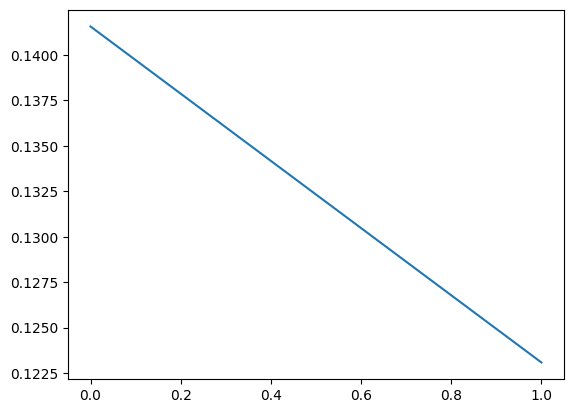

In [75]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [76]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [79]:
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)

  # Convert 1D target tensor to 2D one-hot encoded tensor
  y_one_hot = F.one_hot(y, num_classes=80).float()
  y_one_hot = y_one_hot.long()

  loss = F.cross_entropy(logits, y_one_hot)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.327812671661377
val 1.329339623451233


In [104]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(str(ix.item()) for ix in x) , '-->', str(y.item()))

00000000000000000000000000000000000000000000000000000000000000000000000005593157657033 --> 43
000000000000000000000000000000000000000000000000000000000000000000000000559315765703343 --> 44
0000000000000000000000000000000000000000000000000000000000000000000000055931576570334344 --> 8
0000000000000000000000000000000000000000000000000000000000000000000000559315765703343448 --> 19
00000000000000000000000000000000000000000000000000000000000000000000055931576570334344819 --> 21
000000000000000000000000000000000000000000000000000000000000000000005593157657033434481921 --> 27
0000000000000000000000000000000000000000000000000000000000000000000559315765703343448192127 --> 41
00000000000000000000000000000000000000000000000000000000000000000055931576570334344819212741 --> 45


In [105]:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 10, 80])

In [118]:
all_outputs = []
for i in range(8):
    output = model(Xtr[[7+i]])
    all_outputs.append(output)

# Concatenate along batch dimension (0)
logits = torch.cat(all_outputs, dim=0)
logits.shape

torch.Size([8, 10, 80])